# Problem set 2

## Team
Please write here your names and team number.

* Team name:
* Team members:

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [38]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 11236 with label: 3


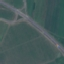

In [39]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

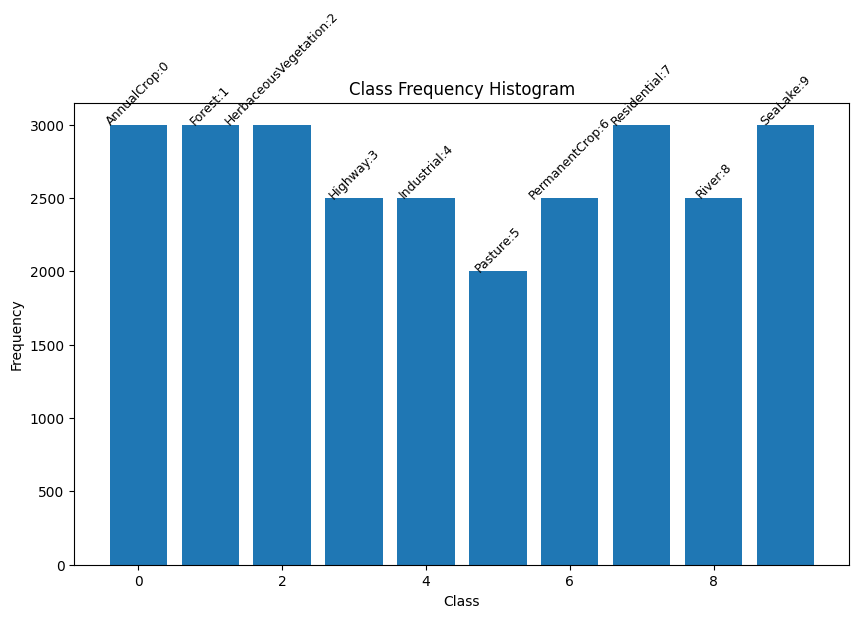

In [45]:
import random
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter

def rotate_picture(picture, rotation):
  """
  Rotate the image by the given degrees: 90, 180, 270, or 360.

  :param picture: Image to rotate
  :param rotation: Rotation in degrees
  :return: Rotated image
  """

  # raise error
  if rotation not in [90, 180, 270, 360]:
    raise ValueError("Rotation angle should be 90, 180, 270, or 360")

  return picture.rotate(rotation)


def plot_histogram(data):
  """

  Plot a histogram with the frequencies of each class.

  data: EuroSAT dataset
  return: fig, ax
  """

  fig, ax = plt.subplots(figsize=(10, 6))

  # Extract labels from dataset
  labels = [item[1] for item in data]

  # Get class names from the dataset
  classes_names = data.classes

  # calculate frequencies of each class
  label_counts = Counter(labels)

  # prepare data for plotting
  label_indices = list(label_counts.keys())
  counts = list(label_counts.values())
  class_labels = [classes_names[idx] for idx in label_indices]  # Map labels to class names


  # plot the histogram
  ax.bar(label_indices, counts)
  ax.set_xlabel('Class')
  ax.set_ylabel('Frequency')
  ax.set_title('Class Frequency Histogram')

  # annotating each bar with the count
  for i, count in enumerate(counts):
    ax.text(label_indices[i], count + 0.1, f"{class_labels[i]}:{label_indices[i]}",
            ha='center',rotation=45, fontsize=9)

  return fig, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)
fig, ax = plot_histogram(data)
fig.show()

Text(0.5, 1.0, 'Rotated by 360°')

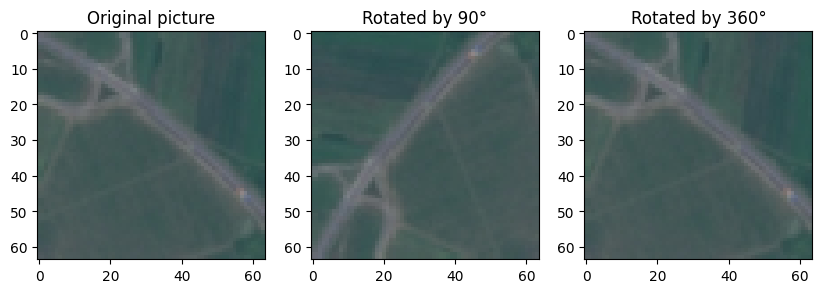

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [47]:
class RotateEuroSAT(Dataset):
    """
    Initialize a rotated EuroSAT dataset.

    This dataset takes an existing EuroSAT dataset and applies random rotations (90°, 180°, 270°, or 360°)
    to the images, and splits them based on the provided class distribution (shares).

    :param original_data: The original EuroSAT dataset.
    :param length: The desired length of the new dataset (i.e., total number of images after rotation).
    :param shares: The distribution shares for each class. The list must sum to 1, and its length must match
                    the number of classes in the original dataset.
    :param device: The device (CPU or GPU) to move the images to. Default is None (images will stay on the CPU).
    :param seed: The random seed for reproducibility. Default is 42.
    """
    def __init__(self,
                 original_data: Dataset,
                 length: int,
                 shares: list,
                 device=None,
                 seed=42):
        self.original_data = original_data
        self.length = length
        assert sum(shares) == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        """
        Returns the length of the rotated dataset.

        :return: The length of the dataset (i.e., the number of images in the rotated dataset).
        :rtype: int
        """
        return self.length

    def __getitem__(self, idx):
        """
        Get an item (rotated image and its label) from the dataset.

        :param idx: The index of the item to fetch from the dataset.
        :type idx: int
        :return: A tuple of the rotated image (tensor) and the label.
        :rtype: tuple (torch.Tensor, int)
        """
        picture, label = self.dataset[idx]

        # Apply transformation to tensor
        picture = self.transform(picture)

        # Optionally move the tensor to the specified device (CPU/GPU)
        if self.device is not None:
            picture = picture.to(self.device)

        return picture, label

    def _create_rotated_dataset(self):
        """
        Create a dataset with rotated images based on the given shares for each class.

        This method rotates images from the original dataset randomly by one of the following angles:
        90°, 180°, 270°, or 360°.

        :return: A list of rotated images and their corresponding labels.
        :rtype: list of tuple (PIL.Image, int)
        """
        random.seed(self.seed)
        rotated_dataset = []

        # Set a start index
        start_idx = 0

        # Create list of the number of each class
        labels = [item[1] for item in self.original_data]
        label_counts_lst = list(Counter(labels).values())

        for class_idx, class_num in enumerate(label_counts_lst):
            # Calculate the number of images for this class based on the share
            class_share = self.shares[class_idx]
            num_class_images = int(class_share * self.length)
            class_images = [i for i in range(start_idx, start_idx + class_num) if self.original_data[i][1] == class_idx]

            # Rotate images
            for img_idx in class_images:
                image, label = self.original_data[img_idx]

                # Rotate the image by one of the allowed angles (90, 180, 270, 360)
                rotation_angle = random.choice([90, 180, 270, 360])
                rotated_image = image.rotate(rotation_angle)

                # Add rotated image and label to the new dataset
                rotated_dataset.append((rotated_image, label))

            start_idx += class_num

        return rotated_dataset




In [49]:
rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             device=device,
                             seed=42,)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [155]:
import torch
import torch.nn as nn
from torchvision import transforms

class MyMaxPool(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super(MyMaxPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self,x):
        return nn.functional.max_pool2d(x,self.kernel_size, self.stride)



class MyCNNModel(nn.Module):
    def __init__(self, num_classes: int = 10):
        """
        Initialize a CNN model with lazy layers that infer input dimensions
        automatically.

        Args:
            num_classes (int): The number of output classes.
        """
        super(MyCNNModel, self).__init__()

        # First Lazy Convolutional Layer (input channels will be inferred)
        self.conv1 = nn.LazyConv2d(out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second Lazy Convolutional Layer (input channels will be inferred)
        self.conv2 = nn.LazyConv2d(out_channels=32, kernel_size=5, stride=1, padding=2)

        # Third Lazy Convolutional Layer (input channels will be inferred)
        self.conv3 = nn.LazyConv2d(out_channels=64, kernel_size=3, stride=1, padding=1)

        # Max Pooling Layer
        self.pool = MyMaxPool(kernel_size=2, stride=2)

        # Fully connected layer will be created lazily (input size inferred)
        self.fc1 = nn.LazyLinear(out_features=64)  # Output will be inferred during the first forward pass
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)  # The final output layer based on the number of classes

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through convolutional layers with ReLU activation and pooling
        x = self.relu(self.conv1(x))  # First conv layer
        x = self.pool(x)  # Pooling

        x = self.relu(self.conv2(x))  # Second conv layer
        x = self.pool(x)  # Pooling

        x = self.relu(self.conv3(x))  # Third conv layer
        x = self.pool(x)  # Pooling

        # Flatten the output before passing to fully connected layers
        x = x.flatten(start_dim=1)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Final output layer

        return x

In [156]:
train_x, train_y = train_data[0]

In [157]:
#print one iteration of your model to test its correctness

my_model = MyCNNModel(num_classes=10).to(device)  # 10 classes for EUROSET database
output = my_model(train_x)
print(" Model test for correctness")
print("Input shape:", train_x.shape)
print("Output shape:", output.shape)



 Model test for correctness
Input shape: torch.Size([3, 64, 64])
Output shape: torch.Size([64, 10])


## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [211]:
import os, datetime, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 50,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:
    """
    Trainer class for training, evaluating, and logging the model's performance.
    """

    def __init__(self,
                 model: torch.nn.Sequential,
                 cfg:dict,
                 device = None,
                 ):
        """
        Initialize.

        :param model: The model to be trained.
        :param cfg: A dictionary containing hyperparameters such as batch size, optimizer, etc.
        :param device: The device (CPU or GPU) on which the model will be trained. Defaults to None.
        """
        self.model = model
        self.cfg = cfg
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # Move the model to the specified device

        # lists to store loss and accuracy for plotting
        self.all_avg_acc=[]
        self.all_avg_loss=[]

    def torch_train(self, data, shuffle=False):
        """
        Train model

        :param data: train data
        :param shuffle: boolean whether shuffle or not.
        :return: trained model
        """
    # Get the loss function (criterion) based on the provided config
        criterion = getattr(nn, self.cfg['criterion'])()  # CrossEntropyLoss, etc.

        # Initialize the optimizer based on the provided config
        optimizer = getattr(optim, self.cfg['optimizer'])(
            self.model.parameters(), lr=self.cfg['learning_rate']
        )

        # Set the model to training mode
        self.model.train()

        # Create DataLoader for the training data
        dataloader = DataLoader(data,
                                batch_size=self.cfg['batch_size'],
                                shuffle=shuffle)

        running_loss = 0
        correct_preds = 0
        total_preds = 0
        for epoch in range(self.cfg['epochs']):

          for x, y in tqdm(dataloader):  # tqdm is used to display a progress bar
            x = x.to(self.device)  # move input data to the device (GPU/CPU)
            y = y.to(self.device)  # move target labels to the device (GPU/CPU)


            # zero the gradients before the forward pass
            optimizer.zero_grad()

            # forward pass: get model predictions
            pred = self.model(x)

            # calculate the loss
            loss = criterion(pred.squeeze(-1),y.long())

            # backward pass: calculate gradients
            loss.backward()

            # update model parameters based on gradients
            optimizer.step()

            # update running loss
            running_loss += loss.item() * x.size(0)

            # calculate accuracy: compare predicted and true labels
            _, predicted = torch.max(pred, 1)
            correct_preds += (predicted == y).sum().item()
            total_preds += y.size(0)

          # calculate average loss and accuracy for this epoch
          avg_loss = running_loss / total_preds
          avg_acc = correct_preds / total_preds
          self.all_avg_acc.append(avg_acc)
          self.all_avg_loss.append(avg_loss)

        return self.model
    def plot_training_metric(self):
        """
        Plot the training loss and accuracy per epoch.
        """
        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.all_avg_loss, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.all_avg_acc, label='Train Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')

        plt.show()

    def evalute_test(self, model, test_data):
        """
        evalute model with test data

        :param model: trained model
        :param test_data: test data
        :return: avg accuracy
        """
        # create DataLoader for the test data
        dataloader = DataLoader(test_data,
                                batch_size=self.cfg['batch_size'],
                                shuffle=False)
        # get a batch of test data
        x_test, y_test = next(iter(dataloader))
        x_test = x_test.to(self.device)
        y_test = y_test.to(self.device)

        # get model predictions
        pred = model(x_test)

        # get the predicted class with the highest probability
        y_pred = pred.argmax(dim=-1)

        # calculate the average accuracy
        avg_acc = (y_pred == y_test).float().mean().item()

        return avg_acc





In [212]:
# Assuming `train_data` and `val_data` are already defined and are instances of DataLoader
my_model = MyCNNModel(num_classes=10).to(device)
trainer = Trainer(model=my_model, cfg=cfg, device=device)
train_model = trainer.torch_train(train_data)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

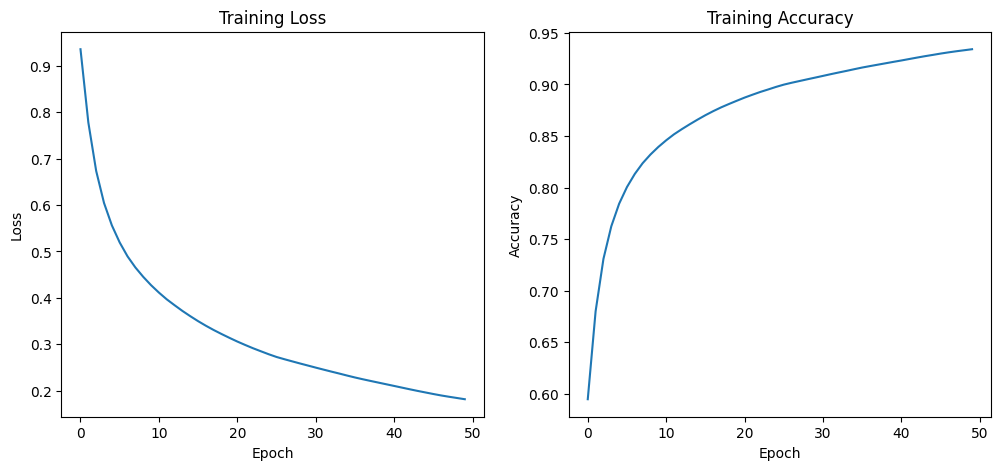

In [213]:
trainer.plot_training_metric()

In [216]:
print(f"Test Accurcay: {trainer.evalute_test(train_model, test_data)}")

Test Accurcay: 0.953125


## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [ ]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    '''#TODO: here your code '''
    return best_model, best_cfg, best_avg_loss, best_avg_acc


best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy").


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [ ]:
'''#TODO: import and fine-tune a pretrained model'''
loaded_model = None #here your loaded model
loaded_trainer = Trainer(loaded_model, cfg)

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             



